In [4]:
# The code was removed by Watson Studio for sharing.

### Data exploration

In [7]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn import metrics

students_perform.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [9]:
# are there any missing values in the original data?
missing_val_count_by_column = (students_perform.isnull().sum())  # for each column, count the number of missing entries
print(missing_val_count_by_column)

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


We want to get a correlation matrix and for that, we transform categorical values into numeric values.

In [42]:
#function that encodes a categorical feature into a numerical value and returns a pd 

def convert_to_num(feature): #feature name as string
    f_cat_encoded, f_categories=students_perform[feature].factorize()
    result=pd.DataFrame(f_cat_encoded, columns=[feature+'_class'])
    return result



#### New feature: math level

In [44]:
threshold=70
students_perform['math level']=(students_perform['math score']>threshold)*1


In [45]:
students = pd.concat([students_perform, convert_to_num("gender"), convert_to_num("race/ethnicity"), convert_to_num("test preparation course")], axis=1)
students

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math level,gender_class,race/ethnicity_class,test preparation course_class
0,female,group B,bachelor's degree,standard,none,72,72,74,1,0,0,0
1,female,group C,some college,standard,completed,69,90,88,0,0,1,1
2,female,group B,master's degree,standard,none,90,95,93,1,0,0,0
3,male,group A,associate's degree,free/reduced,none,47,57,44,0,1,2,0
4,male,group C,some college,standard,none,76,78,75,1,1,1,0
5,female,group B,associate's degree,standard,none,71,83,78,1,0,0,0
6,female,group B,some college,standard,completed,88,95,92,1,0,0,1
7,male,group B,some college,free/reduced,none,40,43,39,0,1,0,0
8,male,group D,high school,free/reduced,completed,64,64,67,0,1,3,1
9,female,group B,high school,free/reduced,none,38,60,50,0,0,0,0


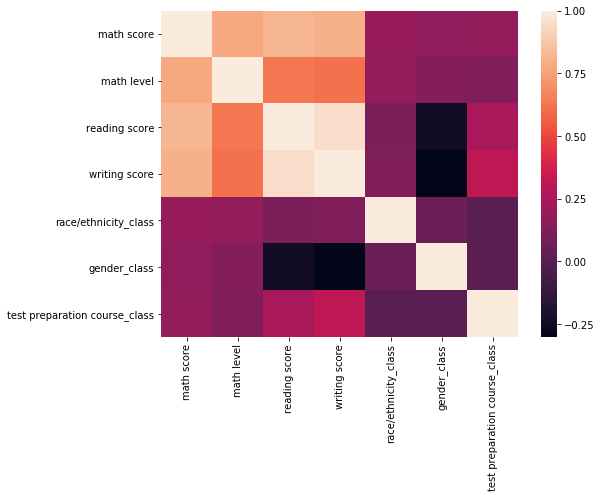

In [46]:
#correlation matrix for some features of interest
plt.figure(figsize=(8,6)) 
sns.heatmap(students[['math score', 'math level', 'reading score', 'writing score', 'race/ethnicity_class', 'gender_class', "test preparation course_class"]].corr())

### Goal

The aim is to build a naive Bayes classifier, such that given the gender and reading score of a student it predicts his/her the math level.
The correlation of 'gender_class' and 'reading score' is around -0.25, which is close to 0. For our purpose, let's assume these two random variables are independent. 

Mathematically, if B=math level, C=gender_class and A=reading score are random variables with A and C independent, then by Bayes' theorem the formula for the prosterior probability of B given A and C is :

Prob(B|A and C)= Prob(A|B)*Prob(C|B)*Prob(B)/Prob(A and C).

For a Bayes classifier, it is enough to determine Prob(B), Prob(A|B), Prob(C|B) and ignore Prob(A and C).

### Data preprocessing

In [47]:
features=students.loc[:,[ 'gender_class', 'reading score']]
labels=students.loc[:,['math level']]

# training and test sets
features_train, features_test, labels_train, labels_test=train_test_split(features, labels, test_size=0.1, random_state=1)
print("Size of train set: ", features_train.shape[0])
print("Size of test set: ", features_test.shape[0])

Size of train set:  900
Size of test set:  100


We use the training set to determine probability distributions.

### Prior probability distribution 

In [48]:
# Prob(B), probability that a randomly selected student from the training set is at math level '0' or '1'

def get_prior_probability(labels):
    
    prior={}
    N=labels.shape[0]
    occurence0=(labels['math level']==0).sum()
    prior[0]=occurence0/N
    occurence1=(labels['math level']==1).sum()
    prior[1]=occurence1/N
    return prior

prior=get_prior_probability(labels_train)
print ("Probability distribution of 'math level' encoded as a dictionary: ",  prior) 


Probability distribution of 'math level' encoded as a dictionary:  {0: 0.6044444444444445, 1: 0.39555555555555555}


### Conditional probabilities

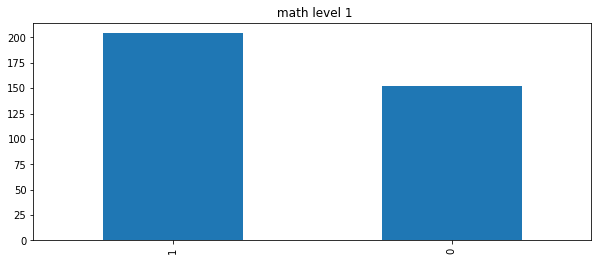

Probability distribution of gender: 
 {0: 0.42696629213483145, 1: 0.5730337078651685}


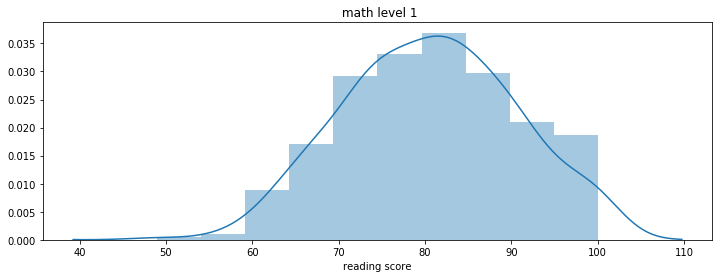

Distribution of reading scores: 
  {'mean': 80.61516853932584, 'std': 9.915128335801542}


In [49]:
#Prob(A|B), Prob(C|B), distributions of 'gender_class' and 'reading score' given the 'math level'

students_train=pd.concat([features_train, labels_train], axis=1)
gen_class=np.unique(features_train['gender_class'])


#histogram for gender_class within  math level=1

plt.figure(figsize=(10,4))
gender_count=students_train[students_train['math level']==1]['gender_class'].value_counts()
gender_count.plot(kind='bar')
plt.title(" math level 1")
plt.show()

#probability distribution of gender  

prob1_gender={}
for i in gen_class:
    prob1_gender[i]=gender_count[i]/gender_count.sum()
print('Probability distribution of gender: \n', prob1_gender)


# histogram of reading score within math level=1
plt.figure(figsize=(12,4))
scores=students_train[students_train['math level']==1]['reading score']
sns.distplot(scores, bins=10)
plt.title(" math level 1")
plt.show()

#probability distribution of reading score 

prob1_read={}
prob1_read["mean"]=np.mean(scores)
prob1_read["std"]=np.std(scores)
print("Distribution of reading scores: \n ", prob1_read)


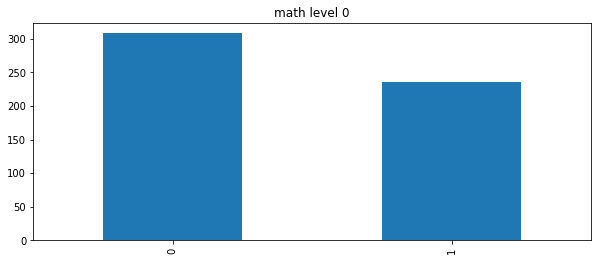

Probability distribution of gender: 
 {0: 0.5661764705882353, 1: 0.4338235294117647}


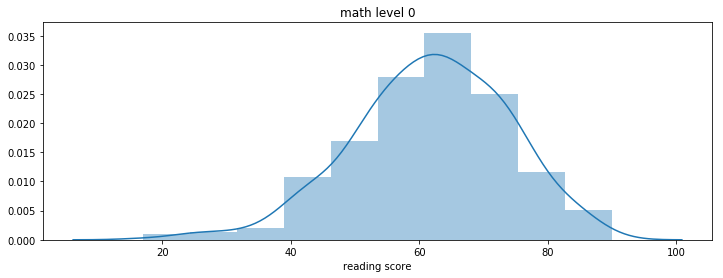

Probability distribution of reading score: 
 {'mean': 61.748161764705884, 'std': 12.183228750924837}


In [50]:
#distributions for math level 0

#histogram of gender_class
plt.figure(figsize=(10,4))
count_gender=students_train[students_train['math level']==0]['gender_class'].value_counts()
count_gender.plot(kind='bar')
plt.title("math level 0")
plt.show()

#probability distribution of gender_class
prob0_gender={}
for i in gen_class:
    prob0_gender[i]=count_gender[i]/count_gender.sum()
print('Probability distribution of gender: \n', prob0_gender)


#histogram of 'reading score'

plt.figure(figsize=(12,4))
scores=students_train[students_train['math level']==0]['reading score']
sns.distplot(scores, bins=10)
plt.title("math level 0")
plt.show()

#probability distribution of reading scores
prob0_read={}
prob0_read["mean"]=np.mean(scores)
prob0_read["std"]=np.std(scores)
print('Probability distribution of reading score: \n', scores0)


In [51]:
# we encode the statistics above into a dictionary
model={0:[prob0_gender, prob0_read], 1:[prob1_gender, prob1_read]}
model

{0: [{0: 0.5661764705882353, 1: 0.4338235294117647},
  {'mean': 61.748161764705884, 'std': 12.183228750924837}],
 1: [{0: 0.42696629213483145, 1: 0.5730337078651685},
  {'mean': 80.61516853932584, 'std': 9.915128335801542}]}

We determined the distributions of 'gender' within 'math level' and the mean and standard deviation of 'reading score' dstributions.

Based on the histograms, we assume the distribution of the 'reading score' is approximated by a Gaussian distribution with mean and variance which are the statistics stored in model.

In [52]:
# given value x of reading score, this function computes P(x|math level=0), P(x|math level=1) based on the Gaussian distribution
def normal_distrib(x, prob_dict):
    mean=prob_dict["mean"]
    std=prob_dict["std"]
    p=1/np.sqrt(2*np.pi*pow(std,2))*np.exp(-(pow((x-mean),2)/(2*pow(std,2)))) 
    return p


### Posterior probability

In [53]:
#given a vector of features [gender, reading score], what is the probability of 'math level' ?
def getPosterior(feature_vec, model, prior):
    posteriors={}
    for className in np.unique(labels):
        p=prior.get(className, None)
        p=p*model[className][0][feature_vec[0]]*normal_distrib(feature_vec[1], model[className][1]) # we ignore the P(A and C) term in the Bayes' formula 
                                                                                                    #because it doesn't affect classification
        posteriors[className]=p
    return posteriors


In [54]:
# function returns label corresponding to highest posterior probability value given feature vector x
def classify(x, model, prior):
    posteriors=getPosterior(x, model, prior)
    inverse = [(value, key) for key, value in posteriors.items()]
    m=max(inverse)[1]  
    return m

print("Example: ")
print("Given gender=1 and reading score=75, the most likely math level of this student is:", classify(np.array([1,75]), model, prior))


Example: 
Given gender=1 and reading score=75, the most likely math level of this student is: 1


### Accuracy of the naive Bayes classifier 

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

pred_train=[classify(x,model, prior) for x in features_train.values] 
print(" Train set weighted accuracy: %.2f\n" % balanced_accuracy_score(labels_train, pred_train)) # we use a weighted accuracy because the two labels are unevenly distributed
c_train=confusion_matrix(labels_train, pred_train)
print("Confusion matrix for the trainining set:\n ", c_train)

pred_test=[classify(x,model, prior) for x in features_test.values]
c_test = confusion_matrix(labels_test, pred_test)
print("Test set weighted accuracy: %.2f\n" % balanced_accuracy_score(labels_test, pred_test))

print("Confusion matrix for the test set:\n ", c_test)


 Train set weighted accuracy: 0.82

Confusion matrix for the trainining set:
  [[466  78]
 [ 74 282]]
Test set weighted accuracy: 0.87

Confusion matrix for the test set:
  [[56  9]
 [ 4 31]]
